In [1]:
import torch
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from chess_rating_net import ChessEloPredictor
from chess_rating_net import time_to_seconds
from util import get_device

/var/folders/9v/ngk5y1xx5rx4d_zqj33qpjd80000gn/T/ipykernel_54936/702890738.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(model_path, map_loca

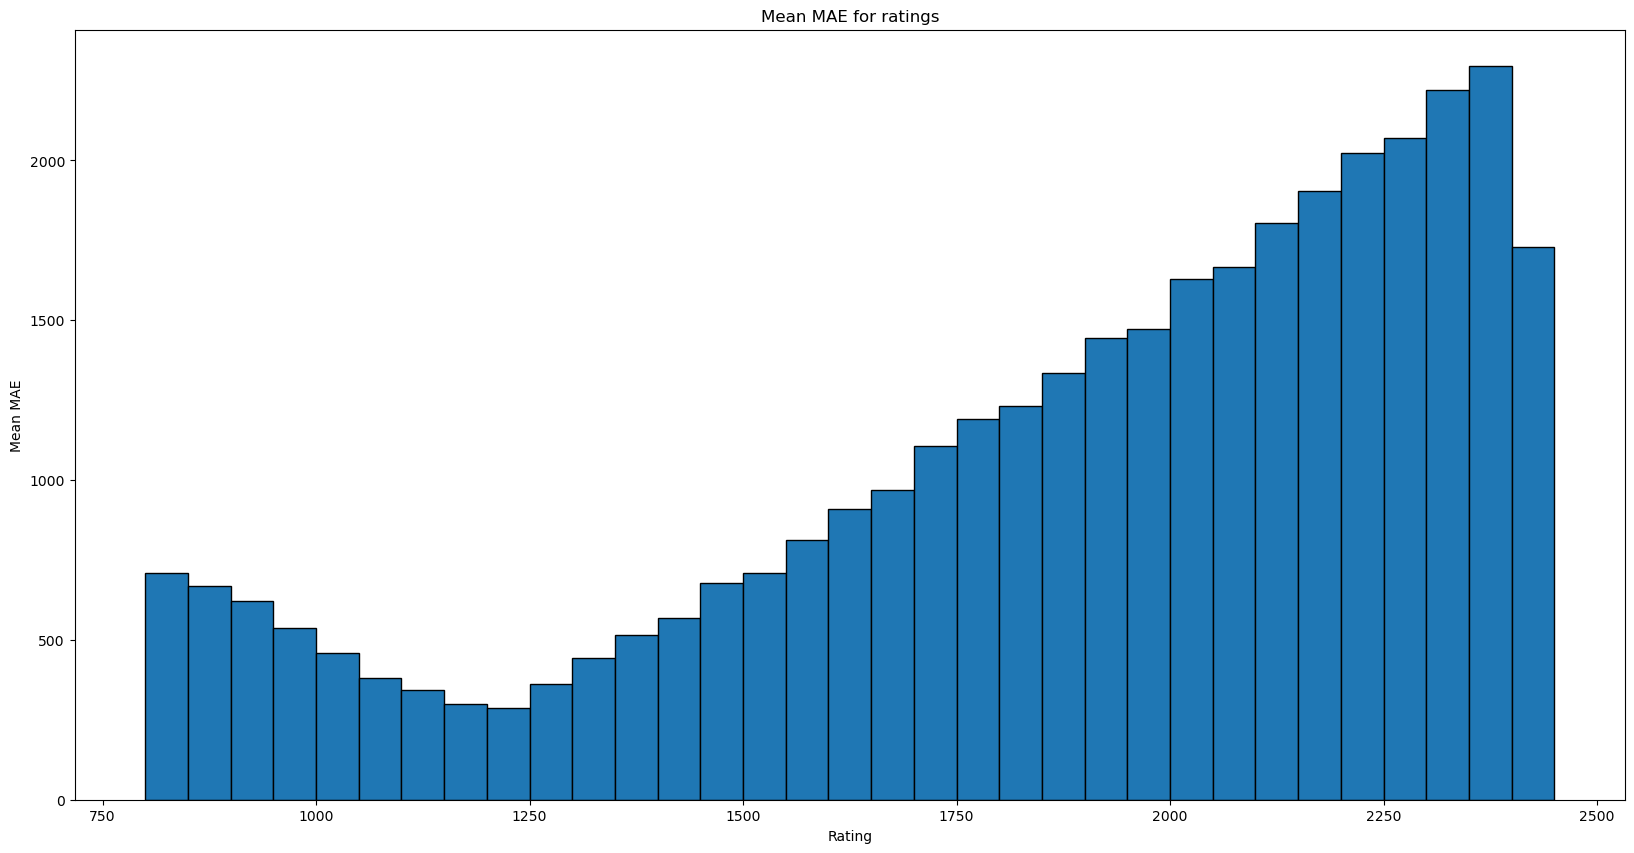

In [3]:
from collections import defaultdict


# This file will output some sample game predictions to text files

def calculate_mae(predictions, white_elo, black_elo):
    mae_white = np.abs(predictions[:, 0] - white_elo)
    mae_black = np.abs(predictions[:, 1] - black_elo)
    return np.mean(mae_white + mae_black)

def save_game_to_txt(file_path, lines, output_dir, suffix, mae):
    output_file_name = os.path.splitext(os.path.basename(file_path))[0] + f'_{suffix}.txt'
    output_file_path = os.path.join(output_dir, output_file_name)
    
    with open(output_file_path, 'w') as output_file:
        for line in lines:
            output_file.write(line + '\n')
        output_file.write(f'MAE: {mae}')

def load_model_and_calculate_error(model_path, data_dir):
    device = get_device()
    
    params = {
        'train_batch_size': 32,
        'val_batch_size': 8192,
        'num_workers': 16,
        'learning_rate': 0.0001,
        'weight_decay': 1e-5,
        'epochs': 100,
        'optimizer': 'Adam',
        'patience': 5,
        'lr_factor': 0.5,
        "conv_filters":32,
        "lstm_layers":3,
        "bidirectional":True,
        "dropout_rate":0.5,
        "lstm_h":64,
        "fc1_h":32
    }
    model = ChessEloPredictor(params["conv_filters"], params["lstm_layers"], params["dropout_rate"],
                              params["lstm_h"], params["fc1_h"], params["bidirectional"]).to(device)
    # If cuda is available, load the model to the GPU
    if torch.cuda.is_available():
        saved_model = torch.load(model_path)
    else:
        saved_model = torch.load(model_path, map_location=torch.device('cpu'))

    model.load_state_dict(saved_model["model_state_dict"])
    model.eval()
    
    all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pkl')]
    train_val_files, test_files = train_test_split(all_files, test_size=0.1, random_state=42)
    
    bin_range = (900, 2400)
    bin_size = 50
    rating_bins = defaultdict(lambda : [0, 0])  # {bin: [count, total_mae]}
    
    for file_path in test_files:
        with open(file_path, 'rb') as f:
            game_info = pickle.load(f)
        
        clocks = [time_to_seconds(c) for c in game_info.get('Clocks', [])]
        clocks = torch.tensor(clocks, dtype=torch.float).to(device)
        
        positions = torch.stack(game_info['Positions']).to(device)
        
        with torch.no_grad():
            outputs, last = model(positions.unsqueeze(0), clocks.unsqueeze(0), torch.tensor([len(positions)]))
            predictions = outputs.squeeze().cpu().numpy()
        
        ratings_mean = 1650
        ratings_std = 433
        predictions = predictions * ratings_std + ratings_mean
        white_elo, black_elo = float(game_info['WhiteElo']), float(game_info['BlackElo'])

        mae = calculate_mae(predictions, white_elo, black_elo)
        
        # Prepare data to save to a text file
        lines = []
        # moves = game_info.get('Moves', [])
        # clocks = clocks.cpu().numpy()
        # for i in range(len(moves[:100])):
        #     white_pred = predictions[i, 0]  # White's predicted rating
        #     black_pred = predictions[i, 1]  # Black's predicted rating
        #     line = (f"Move: {moves[i]}, ClockTime: {clocks[i]}, "
        #             f"PredictedWhiteRating: {white_pred}, PredictedBlackRating: {black_pred}, "
        #             f"WhiteElo: {white_elo}, BlackElo: {black_elo}")
        #     lines.append(line)
        
        white_bin = (white_elo - bin_range[0]) // bin_size
        black_bin = (black_elo - bin_range[0]) // bin_size
        
        rating_bins[white_bin][0] +=1 
        rating_bins[black_bin][0] +=1 
        
        rating_bins[white_bin][1] += mae
        rating_bins[black_bin][1] += mae
        
        # Track the games with the lowest and highest MAE
        
    
    # Save the game with the lowest MAE
    plt.figure(figsize=(20, 10))
    sorted_rating_bins = sorted(rating_bins.items())
    plt.bar([bin_range[0] + x[0] * bin_size for x in sorted_rating_bins], [x[1][1] / x[1][0] for x in sorted_rating_bins], width=bin_size, align="edge", edgecolor="black")
    plt.title("Mean MAE for ratings")
    plt.xlabel("Rating")
    plt.ylabel("Mean MAE")

# Example usage
model_path = 'models/2024-09_games_60+0_382004_MSE/model_37.pth'
data_dir = 'data/processed_games'
load_model_and_calculate_error(model_path, data_dir)
